# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

In [32]:
import pandas
import serial   # pip install pyserial, not pip install serial !
import matplotlib.pyplot as plt

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [3]:
# Serial port parameters
port = '/dev/ttyUSB1'   # Depends on the OS
baud = 9600
timeout = 3

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [4]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('UTF-8').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

In [6]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step, max_pwm):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step), str(max_pwm)])
    return message

def build_message(list_of_string):
    message = " ".join(list_of_string)
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    ser.flush()
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            print("Finished")
            break

        # Forced stop
        if line == 'STOP':
            file.close()
            print("Stopped")
            break

        # Exception unhandled
        if line == 'Arduino is ready':
            print("Exception occured")
            break

        # If I'm here it is a proper sample
        print(line)
        values = line.split(',')
        if 'Message' in values[0]:
            continue
        
        csv_writer.writerow(values)

Finally we can collect the data

### Operating point

In [7]:
command = "O"
filename = "Operating_point.csv"

In [14]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command]), filename)

Message received: O. Response:
OP
0.243
Finished


In [19]:
data_frame_op = pandas.read_csv(filename)
operating_point_thrust = data_frame_op['OP'][0] * 9.81
print(f"{operating_point_thrust} N")

2.38383 N


### Ramp response
To get the data, we first must send a message to the board to tell how to measure. We have to send:
- command R to tell the board to test a ramp
- how many samples to average for each input value
- the distance between input values
- minimum and maximum values to be tested

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [11]:
# Collect the data for the ramp
command = 'R'   # Measure
n_samples = 10  # How many samples do I want to average for each input value
step = 5      # Step for the input signal
min_pwm = 1180   # Start from here
max_pwm = 1400 # Max value to test
filename = "Dataset_ramp copy.csv"

In [ ]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(n_samples), str(step), str(min_pwm), str(max_pwm)]), filename)

#### Plot
Check that the data we got is good

In [12]:
data_frame_ramp = pandas.read_csv(filename)
print(data_frame_ramp.tail())

        PWM       RPM  Thrust
120  1780.0  9263.889   0.736
121  1785.0  9288.803   0.731
122  1790.0  9296.439   0.727
123  1795.0  9259.141   0.728
124  1800.0  9256.903   0.727


<Axes: xlabel='RPM', ylabel='Thrust'>

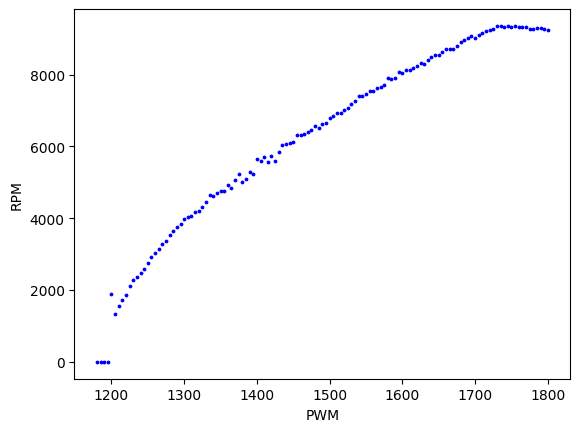

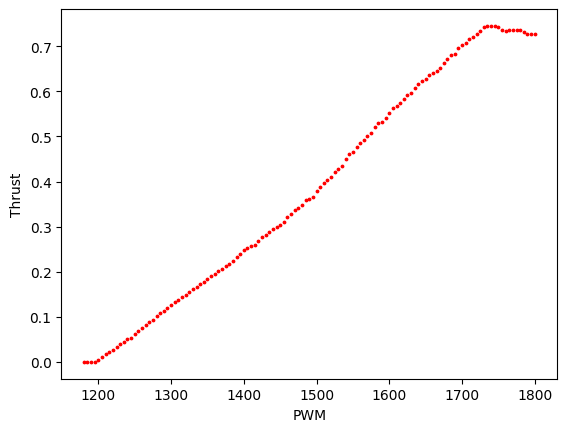

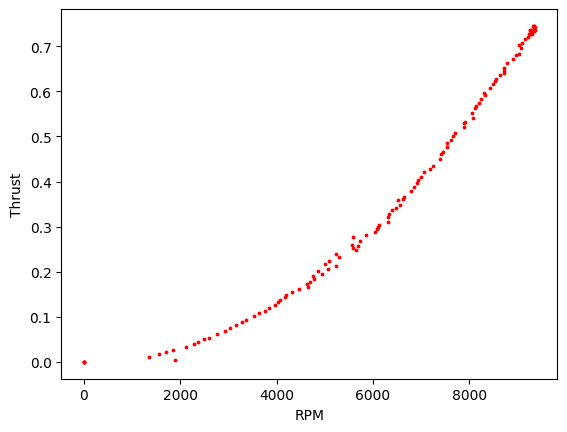

In [13]:
data_frame_ramp.plot(x='PWM', y='RPM', kind='scatter', s=3, c='blue')
data_frame_ramp.plot(x='PWM', y='Thrust', kind='scatter', s=3, c='red')
data_frame_ramp.plot(x='RPM', y='Thrust', kind='scatter', s=3, c='red')

## Step response
Now we measure the step response of the propeller.

The value at which we measure it coincides with the chosen operating point in the final system.

The command is built as follows:
- command S to tell the board to test a step
- operating point: the equilibrium point we operate at. It will be set as baseline for 2 seconds
- step value: offset from the operating point to test (ie the step amplitude)
- max_time: for how much time we test the step before stopping the motor

In this test, the board will send the data all together at the end, due to high frequency interrupts needed to study the fast dynamics of the motor

In [29]:
command = 'S'
operating_point_angle = 69.51
operating_point_pwm = int(operating_point_angle*1000/180 + 1000)
print(operating_point_pwm)
step_value = 200
max_time = 2000    # milliseconds
filename = 'Dataset_step.csv'

1386


In [34]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(operating_point_pwm), str(step_value), str(max_time)]), filename)

Message received: S 1386 200 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
208, 288.200
261, 1130.391
300, 1546.950
329, 2041.580
352, 2597.965
371, 3107.359
388, 3553.029
404, 3875.468
418, 4109.589
432, 4290.925
446, 4440.498
459, 4561.697
472, 4660.918
484, 4746.835
497, 4815.409
509, 4876.066
521, 4926.513
533, 4969.767
545, 5010.020
557, 5041.593
569, 5071.422
581, 5097.273
593, 5122.951
604, 5142.270
616, 5159.958
628, 5176.876
639, 5192.108
651, 5208.333
662, 5217.845
674, 5229.214
685, 5238.802
697, 5247.048
708, 5255.321
719, 5261.312
731, 5265.929
742, 5274.262
753, 5279.367
765, 5283.085
776, 5286.810
788, 5288.673
799, 5292.405
810, 5297.078
822, 5299.417
833, 5298.949
844, 5304.102
855, 5304.102
867, 5304.571
878, 5303.164
889, 5304.571
901, 5305.978
912, 5307.855
923, 5307.855
935, 5308.325
946, 5306.917
957, 5309.265
969, 5309.265
980, 5307.855
991, 5308.325
1002, 5310.674
1014, 5308.325
1025, 5311.615
1036, 5311.615
1048, 5312.085
1059, 5310.205
1070, 5310.

        T       RPM
344  3953  6083.958
345  3963  6085.193
346  3973  6083.342
347  3982  6085.810
348  3992  6083.958


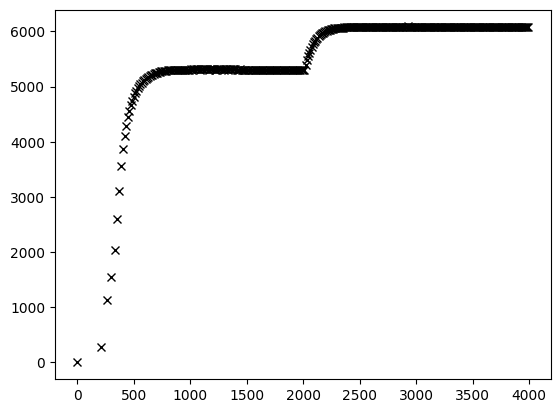

In [35]:
data_frame_step = pandas.read_csv(filename)
print(data_frame_step.tail())
fig,ax = plt.subplots()
ax.plot(data_frame_step['T'], data_frame_step['RPM'], 'kx')